# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Lab assignment №1, part 2
## Gradient boosting on temporal data and feature importances

Today we will work with Gradient Boosting library. It is one of the most popular models these days that shows both great quality and performance.

Choises for library are:

* [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. Handful and fast.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

**Dataset**

By default we will work with widely known [Human Actividy Recognition (HAR) dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones). Data is available at UCI repository.

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.
Some simple preprocessing is done for you.

If you want more interpretable data, you can take [Wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) (see details below).

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [ ]:
# Download and unpack dataset from UCI
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

--2024-12-08 08:36:16--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [ <=>                ]  58.17M  5.48MB/s    in 8.7s    

2024-12-08 08:36:25 (6.69 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314]

Archive:  UCI HAR Dataset.zip
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: UCI HAR Dataset/test/X_test.txt  
  inflating: UCI HAR Dataset/test/y_test.txt  
  inflating: UCI HAR Dataset/train/X_train.txt  
  inflating: UCI HAR Dataset/train/y_train.txt  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


In [ ]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(f"Test set after split: {X_test.shape}, {y_test.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)
Test set after split: (1473, 561), (1473,)
Validation set: (1474, 561), (1474,)


In [ ]:
activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

Let's normalize data

In [ ]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std
X_val = (X_val - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [ ]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [ ]:

X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]
X_val_unique = X_val[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape, X_val_unique.shape

((7352, 540), (1473, 540), (1474, 540))

PCA could be useful in this case. E.g.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train_unique)
X_val_pca = pca.transform(X_val_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape, X_val_pca.shape

((7352, 179), (1473, 179), (1474, 179))

Text(0, 0.5, 'Principal component 2')

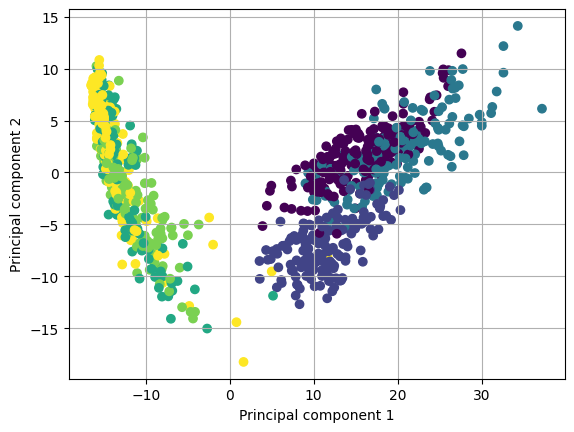

In [ ]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

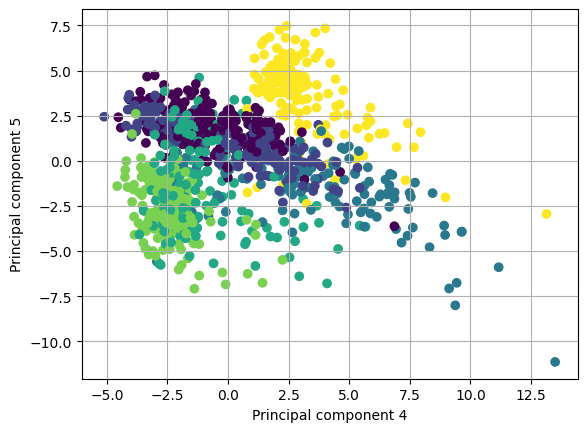

In [ ]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

y_train = y_train - 1
y_test = y_test - 1
y_val = y_val -1

def evaluate_model(params):
    model = XGBClassifier(**params)
    model.fit(X_train_pca, y_train)

    # Оценка на валидационной выборке
    y_val_pred = model.predict(X_val_pca)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Оценка на тестовой выборке
    y_test_pred = model.predict(X_test_pca)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    return val_accuracy, test_accuracy

param_sets = [
    {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100},
    {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200},
    {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150},
    {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 250},
    {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300},
]

for params in param_sets:
    val_accuracy, test_accuracy = evaluate_model(params)
    print(f"Параметры: {params}, val_accuracy: {val_accuracy:.4f}, test_accuracy: {test_accuracy:.4f}")

Параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}, val_accuracy: 0.9111, test_accuracy: 0.8961
Параметры: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}, val_accuracy: 0.9104, test_accuracy: 0.8832
Параметры: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}, val_accuracy: 0.9152, test_accuracy: 0.9063
Параметры: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 250}, val_accuracy: 0.9186, test_accuracy: 0.9104
Параметры: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}, val_accuracy: 0.8616, test_accuracy: 0.8473


Здесь попробовали поэкспериментировать с такими основными гиперпараметрами градиентного бустинга, как шаг сходимости, максимальная глубина дерева и количество итераций. Уже на этом шаге попали в целом хорошо.

In [ ]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/) or [hyperopt](http://hyperopt.github.io/hyperopt/) zero order optimizer to find optimal hyper param set.

In [ ]:
import optuna

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    model = XGBClassifier(**params)
    model.fit(X_train_pca, y_train)

    y_val_pred = model.predict(X_val_pca)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    return val_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_params = study.best_params
best_accuracy = study.best_value
print(f"Лучшие гиперпараметры: {best_params}")
print(f"Лучшее accuracy на валидационной выборке: {best_accuracy:.4f}")

best_model = XGBClassifier(**best_params)
best_model.fit(X_train_pca, y_train)

y_test_pred = best_model.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy на тестовой выборке с лучшими гиперпараметрами: {test_accuracy:.4f}")

[I 2024-12-08 09:08:44,786] A new study created in memory with name: no-name-f8593f36-a6c7-40b5-8d7a-e92f8de131d0
[I 2024-12-08 09:09:07,275] Trial 0 finished with value: 0.8710990502035278 and parameters: {'learning_rate': 0.024017110831344127, 'max_depth': 5, 'n_estimators': 128, 'subsample': 0.9264152091032078, 'colsample_bytree': 0.8449491210601132, 'gamma': 2.9300469126849356, 'min_child_weight': 8}. Best is trial 0 with value: 0.8710990502035278.
[I 2024-12-08 09:09:19,068] Trial 1 finished with value: 0.8995929443690638 and parameters: {'learning_rate': 0.21537664833964976, 'max_depth': 9, 'n_estimators': 222, 'subsample': 0.7450098704884691, 'colsample_bytree': 0.8105630280916862, 'gamma': 4.825113040608661, 'min_child_weight': 5}. Best is trial 1 with value: 0.8995929443690638.
[I 2024-12-08 09:09:29,179] Trial 2 finished with value: 0.9158751696065129 and parameters: {'learning_rate': 0.2645988282907909, 'max_depth': 5, 'n_estimators': 254, 'subsample': 0.6721382446456288, 'c

Лучшие гиперпараметры: {'learning_rate': 0.1901518549441206, 'max_depth': 3, 'n_estimators': 178, 'subsample': 0.7242883352260385, 'colsample_bytree': 0.6117817698022173, 'gamma': 0.1435586268939465, 'min_child_weight': 4}
Лучшее accuracy на валидационной выборке: 0.9369
Accuracy на тестовой выборке с лучшими гиперпараметрами: 0.9199


### Conclusion

Используя фреймворк оптюна, мы нашли лучшие гиперпараметры для xgboost с accuracy ~ 0.92, что является хорошим результатом!

## Part 3. Interpret the model predictions

Train model on original feature set and analyze it.

Please use [shap](https://github.com/slundberg/shap) to build beeswarm plot and at least one of your choice and interpret them (write conclusion).

Explanations of features can be found on dataset's UCI page (see dataset downloading section).

In [ ]:
!pip install ucimlrepo

In [ ]:
import ucimlrepo as uci

In [ ]:
dataset = uci.fetch_ucirepo(id=186)

print(dataset.metadata.name, '\n')
print(dataset.metadata.abstract, '\n')
print(dataset.metadata.additional_info.summary, '\n')

Wine Quality 

Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/). 

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].  Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks.  The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to t

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
X = dataset.data.features
y = dataset.data.targets

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.values.ravel())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
! pip install shap

In [ ]:
import shap
from xgboost import XGBClassifier

best_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}
model = XGBClassifier(**best_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

Class 0:


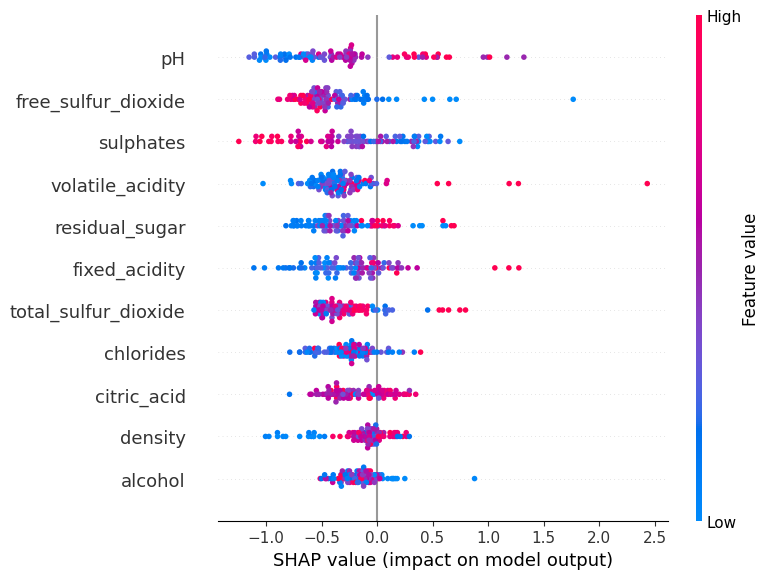

Class 1:


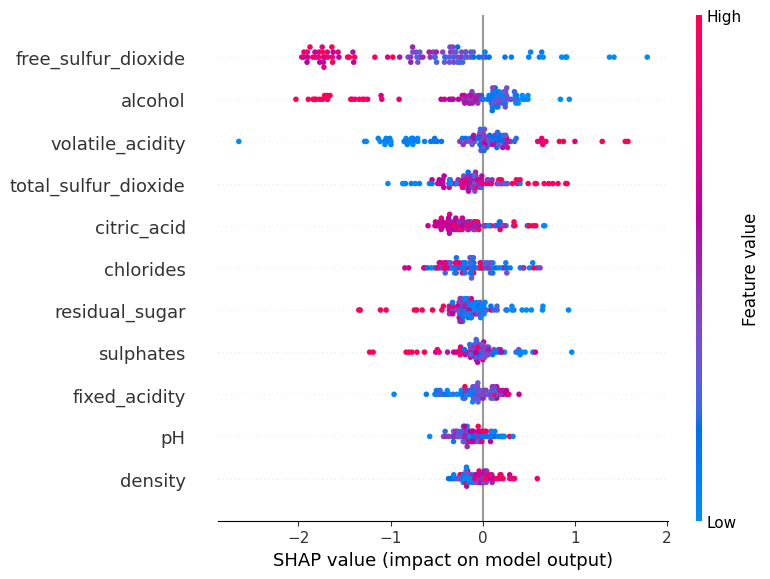

Class 2:


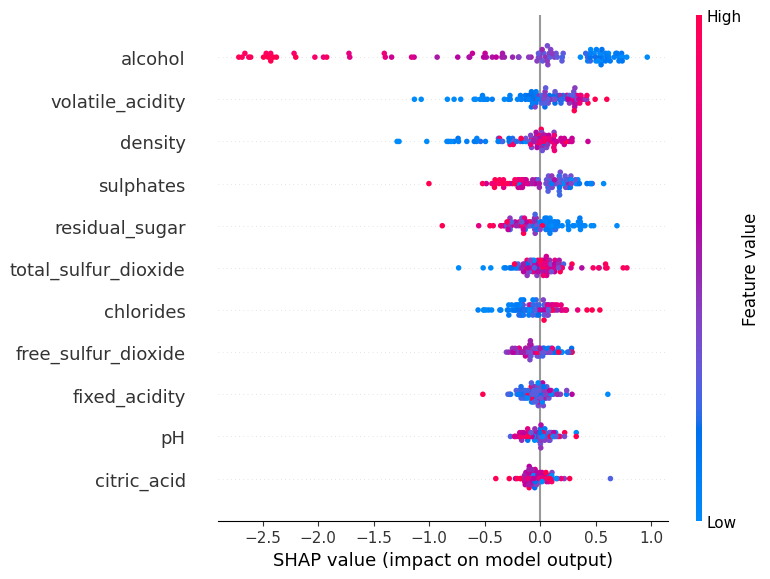

Class 3:


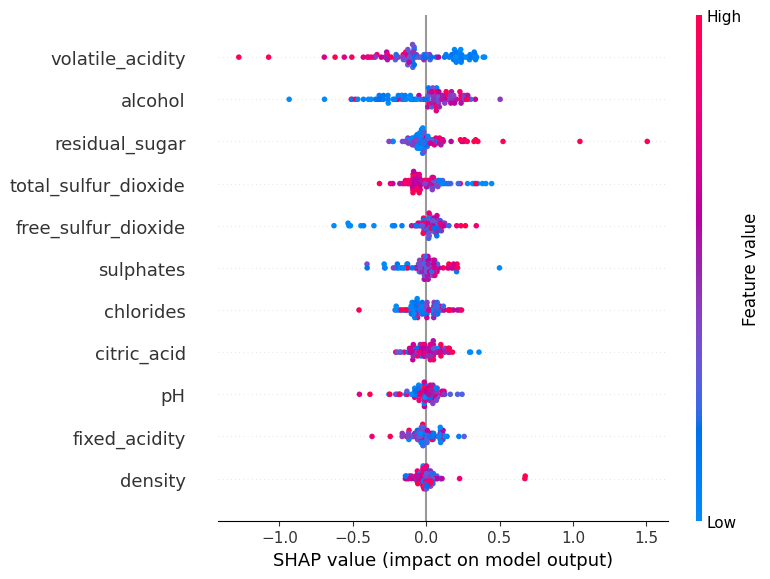

Class 4:


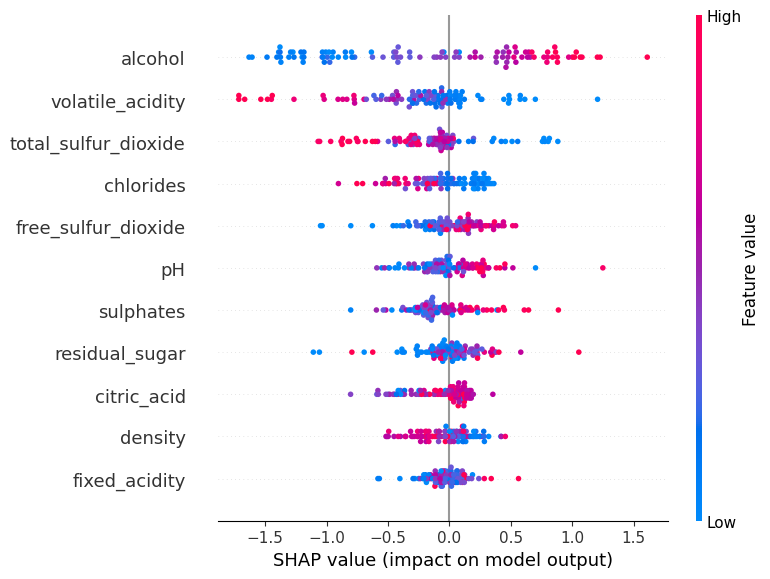

Class 5:


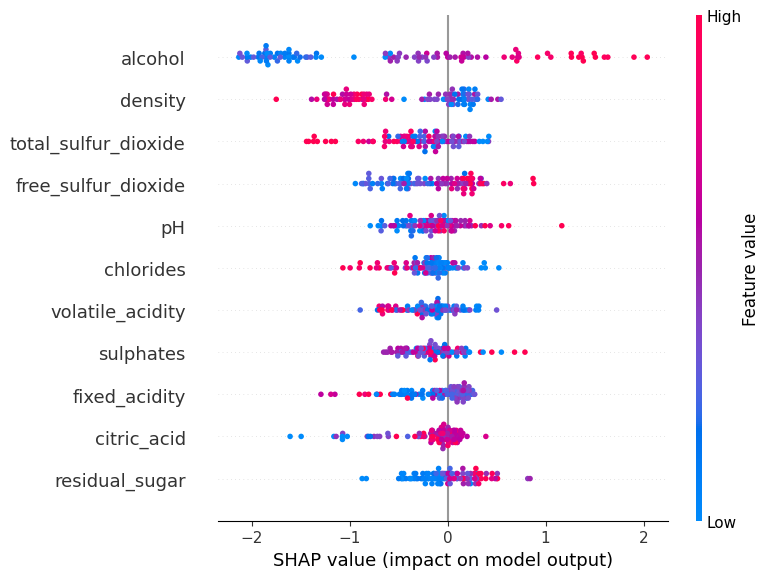

Class 6:


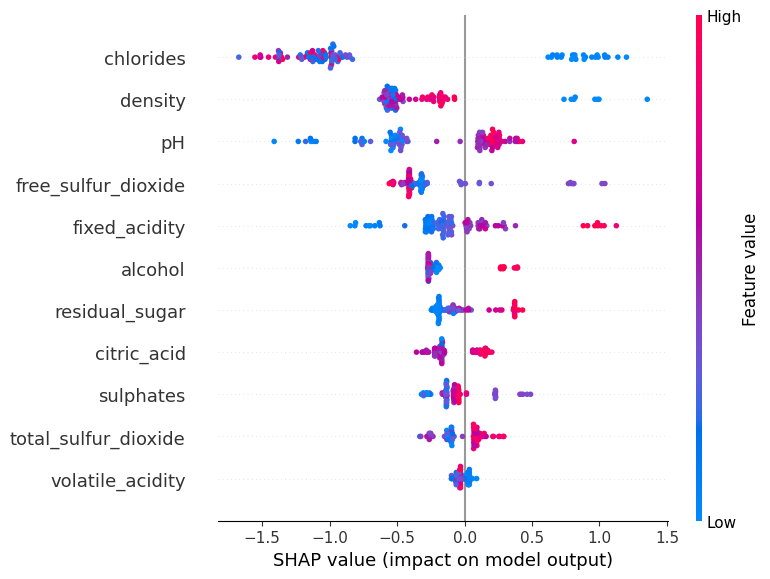

In [ ]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

X_test_sampled = X_test.sample(n=100, random_state=42)
shap_values_sampled = explainer(X_test_sampled)

num_classes = shap_values_sampled.values.shape[2]

for class_idx in range(num_classes):
    shap_values_class = shap_values_sampled.values[:, :, class_idx]

    print(f"Class {class_idx}:")
    shap.summary_plot(
        shap_values_class,
        features=X_test_sampled,
        feature_names=X_test_sampled.columns,
        plot_type="dot",
        max_display=11,
        color=plt.get_cmap("cool"),
        show=True
    )


### Conclusion

Your thoughts about the plots and model behaviour:

Давайте рассмотрим два класса: класс худших вин и класс лучших вин. Вины лучшего качества должны обладать низким уровнем хлоридов, т.к. это придает соленость. Также повышенная плотность вина плохо сказывается на качестве вина. Уменьшение кислотности очень сильно ухудшает качество вина.

Класс плохих вин. Становится очевидным, что первое, что играт роль в качестве вина - это кислотность. Чем она меньше, тем хуже вино. Сначала уменьшение свободного диоксида серы начинает ухудшать вино, а потом с определенного момента от переизбытка этого элемента вину становится еще хуже. В целом все же, чем этой серы меньше, тем лучше. Также высокое содержание сульфатов делает вино даже хуже низкосортного:)

Делая выводы по работе модели, для каждого класса есть свои важные признаки, которые дают модели понять, к какому классу относить то или иное вино. Рассмотрели три самых важных признака для вин низкого качества и высокого.